# Sentiment Analysis using LSTM

Created by Sanjay Raghuwanshi, XAI part added by Marta Kłosok  
Link to original repo containing LSTM part *https://github.com/sanjay-raghu/sentiment-analysis-using-LSTM-keras*

**Created by Sanjay Raghuwanshi ** <br/>
[Github](https://github.com/sanjay-raghu) <br/>
[Linkedin](https://www.linkedin.com/in/sanjayiitg/) <br/>
**Sentiment Analysis:** the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.

**Solving class imbalaned data**:
- upsampling 
- using class weighted loss function

Using LSTM to classify the movie reviews into positive and negative.


#### *Remarks*

To produce the results for DeepExplainer object you need to use Python 3.6 version and 1.14.0 Tensorflow version with latest SHAP package (shap==0.41.0). Rest of the package is listed in requirements.txt. 

In [116]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import re


Reading data and keeping  only the necessary columns.

In [117]:
data = pd.read_csv('../data/Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

Data preview

In [118]:
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


Next, I am dropping the 'Neutral' sentiments as my goal was to only differentiate positive and negative tweets. After that, I am filtering the tweets so only valid texts and words remain.  Then, I define the number of max features as 2000 and use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.

In [119]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
# removing special chars
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data.head()

,text,sentiment
1,rt scottwalker didnt catch the full gopdebate ...,Positive
3,rt robgeorge that carly fiorina is trending h...,Positive
4,rt danscavino gopdebate w realdonaldtrump deli...,Positive
5,rt gregabbott_tx tedcruz on my first day i wil...,Positive
6,rt warriorwoman91 i liked her and was happy wh...,Negative


In [120]:
print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt','')
data.head()

4472
16986


,text,sentiment
1,scottwalker didnt catch the full gopdebate la...,Positive
3,robgeorge that carly fiorina is trending hou...,Positive
4,danscavino gopdebate w realdonaldtrump delive...,Positive
5,gregabbott_tx tedcruz on my first day i will ...,Positive
6,warriorwoman91 i liked her and was happy when...,Negative


In [121]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
X

array([[   0,    0,    0, ..., 1308, 1394,  733],
       [   0,    0,    0, ...,  231,  713,   17],
       [   0,    0,    0, ...,  204,  366,  678],
       ...,
       [   0,    0,    0, ...,   71,   65,    3],
       [   0,    0,    0, ..., 1007, 1406,   74],
       [   0,    0,    0, ...,  194,    3,  712]], dtype=int32)

Next, I compose the LSTM Network. Note that **embed_dim**, **lstm_out**, **batch_size**, **droupout_x** variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. Please also note that I am using softmax as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.

In [122]:
X.shape

(10729, 28)

In [123]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 197       
Total params: 510,997
Trainable params: 510,997
Non-trainable params: 0
_________________________________________________________________
None


Hereby I declare the train and test dataset.

In [124]:
data

,text,sentiment
1,scottwalker didnt catch the full gopdebate la...,Positive
3,robgeorge that carly fiorina is trending hou...,Positive
4,danscavino gopdebate w realdonaldtrump delive...,Positive
5,gregabbott_tx tedcruz on my first day i will ...,Positive
6,warriorwoman91 i liked her and was happy when...,Negative
...,...,...
13866,cappy_yarbrough love to see men who will neve...,Negative
13867,georgehenryw who thought huckabee exceeded th...,Positive
13868,lrihendry tedcruz as president i will always ...,Positive
13869,jrehling gopdebate donald trump says that he ...,Negative


In [125]:
Y = pd.get_dummies(data['sentiment']).values
target = Y[:, 0]
X_train, X_test, Y_train, Y_test = train_test_split(X, target,test_size = 0.20, random_state = 42, shuffle=False)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

X_train_shape = X_train.shape[0]
X_train_shape

(8583, 28) (8583,)
(2146, 28) (2146,)


8583

Here we train the Network. We should run much more than 7 epoch, but I would have to wait forever for kaggle, so it is 7 for now.

In [127]:
batch_size = 128
model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 1)

Epoch 1/15
8583/8583 [==============================] - 10s 1ms/sample - loss: 0.4956 - acc: 0.7937
Epoch 2/15
8583/8583 [==============================] - 8s 981us/sample - loss: 0.3610 - acc: 0.8499
Epoch 3/15
8583/8583 [==============================] - 8s 935us/sample - loss: 0.2950 - acc: 0.8759
Epoch 4/15
8583/8583 [==============================] - 8s 941us/sample - loss: 0.2692 - acc: 0.8882
Epoch 5/15
8583/8583 [==============================] - 8s 940us/sample - loss: 0.2487 - acc: 0.8961
Epoch 6/15
8583/8583 [==============================] - 9s 993us/sample - loss: 0.2381 - acc: 0.9035
Epoch 7/15
8583/8583 [==============================] - 8s 969us/sample - loss: 0.2225 - acc: 0.9078
Epoch 8/15
8583/8583 [==============================] - 8s 938us/sample - loss: 0.2131 - acc: 0.9112
Epoch 9/15
8583/8583 [==============================] - 8s 959us/sample - loss: 0.1924 - acc: 0.9212
Epoch 10/15
8583/8583 [==============================] - 9s 1ms/sample - loss: 0.1807 - acc:

Extracting a validation set, and measuring score and accuracy.

In [128]:
Y_pred = model.predict(X_test, batch_size = batch_size)
Y_pred = [float(x) for x in Y_pred]

In [129]:
Y_pred[0:10]

[0.9890376329421997,
 0.08637002110481262,
 0.9815987348556519,
 0.7783682346343994,
 0.9985710382461548,
 0.760236382484436,
 0.3336275517940521,
 0.9502127170562744,
 0.9989206194877625,
 0.7776509523391724]

# Explain the model with DeepExplainer


In [144]:
import shap


# we use the first 100 training examples as our background dataset to integrate over
# explainer = shap.DeepExplainer(model.predict, X_train[:100])
explainer = shap.DeepExplainer(model, X_train[:500])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test[:10])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 20.7 µs


In [134]:
shap_values[0].shape

(10, 28)

In [135]:
tokenizer.word_index

{'the': 1,
 'gopdebate': 2,
 'gopdebates': 3,
 'to': 4,
 'is': 5,
 'of': 6,
 'a': 7,
 'and': 8,
 'i': 9,
 'rwsurfergirl': 10,
 'you': 11,
 'in': 12,
 'it': 13,
 'for': 14,
 'trump': 15,
 'that': 16,
 'on': 17,
 'fox': 18,
 'not': 19,
 'this': 20,
 'was': 21,
 'about': 22,
 'realdonaldtrump': 23,
 'amp': 24,
 'news': 25,
 'debate': 26,
 'from': 27,
 'have': 28,
 'at': 29,
 'we': 30,
 'me': 31,
 'but': 32,
 'he': 33,
 'be': 34,
 'candidates': 35,
 'just': 36,
 'are': 37,
 'like': 38,
 'last': 39,
 'they': 40,
 'so': 41,
 'gop': 42,
 'dont': 43,
 'megynkelly': 44,
 'with': 45,
 'all': 46,
 'up': 47,
 'what': 48,
 'people': 49,
 'jeb': 50,
 'foxnews': 51,
 'who': 52,
 'my': 53,
 'how': 54,
 'as': 55,
 'if': 56,
 'bush': 57,
 'night': 58,
 'has': 59,
 'no': 60,
 'their': 61,
 'by': 62,
 'when': 63,
 'can': 64,
 'do': 65,
 'one': 66,
 'more': 67,
 'im': 68,
 'out': 69,
 'or': 70,
 'would': 71,
 'his': 72,
 'chris': 73,
 'him': 74,
 'get': 75,
 'think': 76,
 'republican': 77,
 'donald': 78,
 

In [136]:
words_dict = tokenizer.word_index

In [137]:
num2word = {}
for w in words_dict.keys():
    num2word[words_dict[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), X_test[i]))) for i in range(10)])


In [138]:
explainer.expected_value[0]

0.7408539

### Explain first instance from test set

In [139]:
model.predict(X_test)[0]

array([0.98903763], dtype=float32)

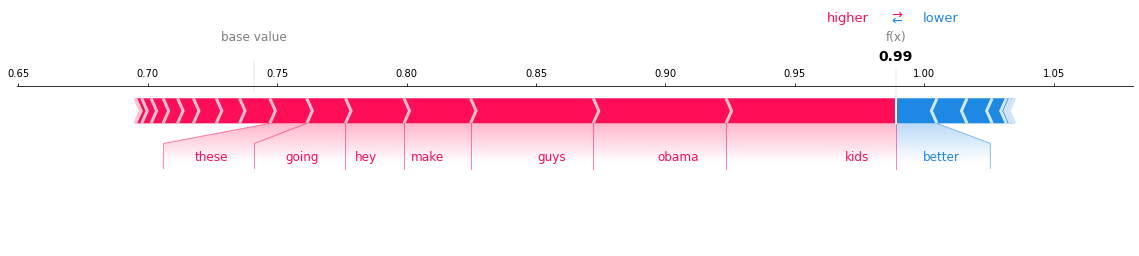

In [140]:
# shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test_words[0], matplotlib=True, show = False)



*True label of the first instance is:*

In [141]:
Y_test[0]

1

In [145]:
data.iloc[X_train_shape]["text"]

' supermanhotmale hey chris wallace these guys have a better plan than president obama make the popcorn kids this is going to be stup'

In [146]:
data.iloc[X_train_shape]["sentiment"]

'Negative'

### Explain second instance from test set

In [147]:
model.predict(X_test)[1]

array([0.08637002], dtype=float32)

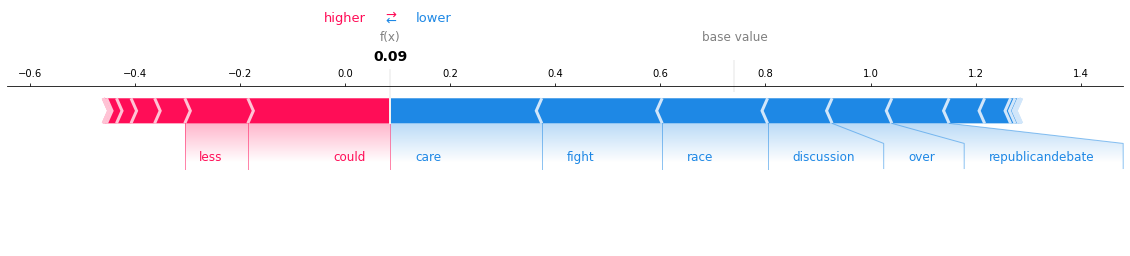

In [148]:
shap.force_plot(explainer.expected_value[0], shap_values[0][1], x_test_words[1], matplotlib=True, show = False)



*True label of the second instance is:*

In [149]:
Y_test[1]

1

In [152]:
data.iloc[X_train_shape+1]["text"]

'race discussion was over quicker than that rousey fight gop could care less about black people republicandebate foxnews gopdebates'

In [153]:
data.iloc[X_train_shape]["sentiment"]

'Negative'

### Explain third instance from test set

In [154]:
model.predict(X_test)[2]

array([0.98159873], dtype=float32)

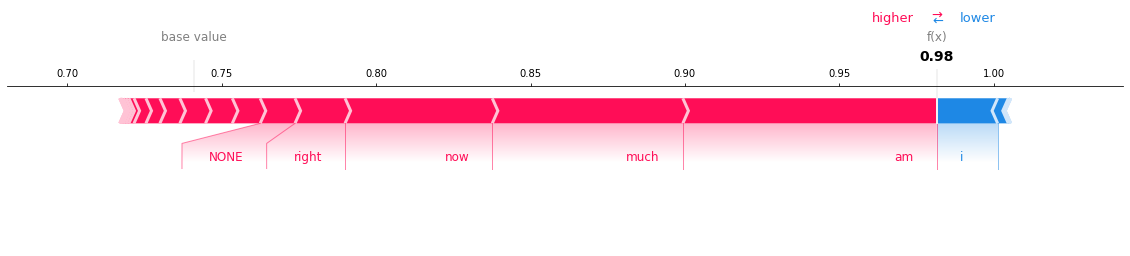

In [155]:
shap.force_plot(explainer.expected_value[0], shap_values[0][2], x_test_words[2], matplotlib=True, show = False)


In [156]:
data.iloc[X_train_shape+2]["text"]

'i am filled with so much joy right now gopdebates'

In [158]:
data.iloc[X_train_shape+2]["sentiment"]

'Positive'

In [163]:
shap_values[0

0.0008787681744147208